<a href="https://colab.research.google.com/github/tj191073-droid/tj191073/blob/main/%E2%80%9Cfishscale_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

# ✅ 环境与路径设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/fish_dataset_split"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
num_classes = len(os.listdir(train_dir))
save_path = "best_model.pth"

# ✅ 参数设置
image_size = 160
batch_size = 8
learning_rate = 3e-4
max_epochs = 50
early_stop_patience = 6

# ✅ 图像增强
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# ✅ 加载数据
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# ✅ 类别权重（应对长尾分布）
weights = compute_class_weight(class_weight="balanced",
                                classes=np.unique(train_data.targets),
                                y=train_data.targets)
weights = torch.tensor(weights, dtype=torch.float).to(device)

# ✅ 加载模型并解冻所有层
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = True
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.to(device)

# ✅ 损失函数与优化器
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ✅ 训练循环
best_val_acc, patience_counter = 0.0, 0
for epoch in range(1, max_epochs + 1):
    # === Train ===
    model.train()
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)
    train_acc = correct / total

    # === Validation ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            correct += (pred.argmax(1) == y).sum().item()
            total += y.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # === Early Stopping ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("⏹️ Early stopping triggered.")
            break

# ✅ 加载最优模型
model.load_state_dict(torch.load(save_path))
print(f"✅ Done. Best Validation Accuracy: {best_val_acc:.4f}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.2MB/s]


Epoch 1: Train Acc = 0.1745, Val Acc = 0.3438
Epoch 2: Train Acc = 0.3552, Val Acc = 0.3917
Epoch 3: Train Acc = 0.4474, Val Acc = 0.4771
Epoch 4: Train Acc = 0.5443, Val Acc = 0.5500
Epoch 5: Train Acc = 0.5964, Val Acc = 0.6167
Epoch 6: Train Acc = 0.6302, Val Acc = 0.6500
Epoch 7: Train Acc = 0.6682, Val Acc = 0.6438
Epoch 8: Train Acc = 0.6865, Val Acc = 0.6438
Epoch 9: Train Acc = 0.7172, Val Acc = 0.6562
Epoch 10: Train Acc = 0.7438, Val Acc = 0.6771
Epoch 11: Train Acc = 0.7589, Val Acc = 0.6562
Epoch 12: Train Acc = 0.7833, Val Acc = 0.6729
Epoch 13: Train Acc = 0.8109, Val Acc = 0.6958
Epoch 14: Train Acc = 0.8161, Val Acc = 0.6896
Epoch 15: Train Acc = 0.8224, Val Acc = 0.6750
Epoch 16: Train Acc = 0.8318, Val Acc = 0.7250
Epoch 17: Train Acc = 0.8505, Val Acc = 0.6500
Epoch 18: Train Acc = 0.8630, Val Acc = 0.7146
Epoch 19: Train Acc = 0.8677, Val Acc = 0.7208
Epoch 20: Train Acc = 0.8521, Val Acc = 0.6771
Epoch 21: Train Acc = 0.8724, Val Acc = 0.7125
Epoch 22: Train Acc = 

In [ ]:
# 保存
torch.save(model.state_dict(), "mobilenetv2_weights.pth")

# 加载
from torchvision import models
model = models.mobilenet_v2()
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)
model.load_state_dict(torch.load("mobilenetv2_weights.pth"))

<All keys matched successfully>

Saving UWZM-F-0004061.JPG to UWZM-F-0004061.JPG


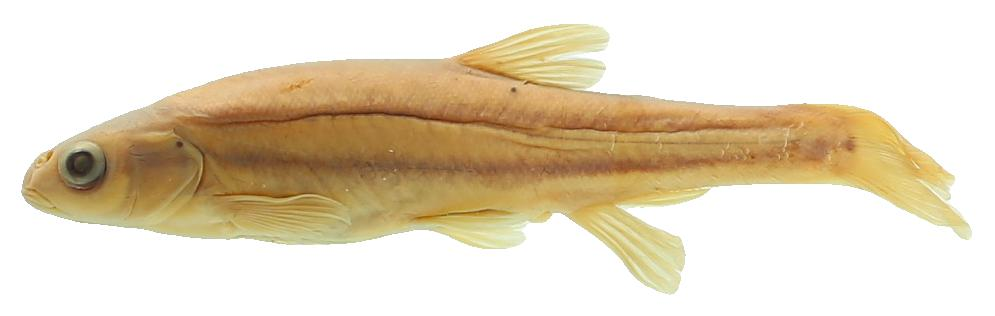


🐟 预测类别：chrosomus erythrogaster
✅ 置信度：86.34%


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
from google.colab import files
from IPython.display import Image as IPyImage, display

# === 1. 设置模型相关参数 ===
weights_path = "mobilenetv2_weights.pth"  # 你的模型权重路径
train_dir = "/content/fish_dataset_split/train"  # 用于获取类别名
image_size = 224
device = torch.device("cpu")

# === 2. 上传图像文件 ===
uploaded = files.upload()  # 你会看到上传按钮
img_path = list(uploaded.keys())[0]
display(IPyImage(img_path))  # 显示上传的图像

# === 3. 加载类别名（按训练集文件夹名排序）===
class_names = sorted(os.listdir(train_dir))

# === 4. 定义预处理方法 ===
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# === 5. 加载模型并恢复权重 ===
model = models.mobilenet_v2()
model.classifier[1] = torch.nn.Linear(model.last_channel, len(class_names))
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)
model.eval()

# === 6. 加载图像、预处理并预测 ===
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    top1_prob, top1_pred = torch.max(probs, 1)
    predicted_class = class_names[top1_pred.item()]
    confidence = top1_prob.item()

print(f"\n🐟 预测类别：{predicted_class}")
print(f"✅ 置信度：{confidence:.2%}")

In [ ]:
# 克隆数据集
!git clone https://huggingface.co/datasets/imageomics/fish-vista
%cd fish-vista

# 安装 Git LFS 并拉取大文件（包括图像）
!git lfs install
!git lfs pull

Cloning into 'fish-vista'...
remote: Enumerating objects: 80157, done.
remote: Total 80157 (delta 0), reused 0 (delta 0), pack-reused 80157 (from 1)
Receiving objects: 100% (80157/80157), 212.04 MiB | 27.64 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Updating files: 100% (75833/75833), done.
Filtering content: 100% (75712/75712), 11.04 GiB | 22.87 MiB/s, done.
/content/fish-vista
Updated git hooks.
Git LFS initialized.


In [ ]:
import os
import pandas as pd

# 读取 CSV 元数据
df = pd.read_csv("/content/fish-vista/classification_train.csv", low_memory=False)

# 仅保留 family 为 Cyprinidae 的记录
cy_df = df[df['family'] == 'Cyprinidae']

# 找出每类图片数 ≥ 60 的种类
species_counts = cy_df['standardized_species'].value_counts()
valid_species = species_counts[species_counts >= 60]

# 随机选取 40 个种类
selected_species = valid_species.sample(n=40, random_state=42).index.tolist()
sub_df = cy_df[cy_df['standardized_species'].isin(selected_species)]

# 每个种类随机抽取 60 张图像
subset = sub_df.groupby('standardized_species', group_keys=False).apply(
    lambda x: x.sample(60, random_state=42)
).reset_index(drop=True)

# 拼接真实图像路径
def resolve_path(file_name):
    try:
        chunk_id = file_name.split('/')[1].split('_')[1]
        return os.path.join("/content/fish-vista/Images", f"chunk_{chunk_id}", os.path.basename(file_name))
    except:
        return None

subset['image_path'] = subset['file_name'].apply(resolve_path)

# 丢弃路径无效的行
subset['image_exists'] = subset['image_path'].apply(lambda x: os.path.exists(x))
subset = subset[subset['image_exists']].reset_index(drop=True)

# 查看结果
print(f"✅ 最终提取：{len(subset)} 张图像，{subset['standardized_species'].nunique()} 个种类")
print(subset[['standardized_species', 'image_path']].head())

✅ 最终提取：2400 张图像，40 个种类
  standardized_species                                         image_path
0    carassius auratus  /content/fish-vista/Images/chunk_2/INHS_FISH_2...
1    carassius auratus  /content/fish-vista/Images/chunk_3/86229_lat_F...
2    carassius auratus  /content/fish-vista/Images/chunk_1/INHS_FISH_1...
3    carassius auratus  /content/fish-vista/Images/chunk_1/100841_lat_...
4    carassius auratus  /content/fish-vista/Images/chunk_3/INHS_FISH_0...


/tmp/ipython-input-2-3253839280.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset = sub_df.groupby('standardized_species', group_keys=False).apply(


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# 设置划分目录
base_dir = "/content/fish_dataset_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# 清除旧目录
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# 创建新目录
for d in [train_dir, val_dir]:
    os.makedirs(d, exist_ok=True)

# 对每一类进行划分并复制图片
for cls in subset['standardized_species'].unique():
    cls_df = subset[subset['standardized_species'] == cls]
    train_imgs, val_imgs = train_test_split(cls_df['image_path'].tolist(), test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for src in train_imgs:
        shutil.copy(src, os.path.join(train_dir, cls, os.path.basename(src)))
    for src in val_imgs:
        shutil.copy(src, os.path.join(val_dir, cls, os.path.basename(src)))

print("✅ 图像划分完成！")

✅ 图像划分完成！
